## **Helper Functions and Packages**

In [5]:
pip install pandas_datareader

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.3.1 -> 25.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [1]:
import gym
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque, namedtuple
import matplotlib.pyplot as plt
import yfinance as yf
import torch.nn.functional as F

fewer_sp500_tickers = [
    "AAPL", "MSFT", "UNH", "LLY", "JPM", "JNJ", "XOM", "WMT", "PG", "CVX",
    "HD", "MRK", "COST", "PEP", "ADBE", "KO", "BAC", "ORCL", "INTC",
    "MCD", "ABT", "CSCO", "QCOM", "DHR", "NKE", "WFC", "TXN", "AMD",
    "NEE", "AMGN", "PM", "HON", "UNP", "UPS", "MS", "LOW", "BA", "IBM",
    "CAT", "MDT", "GS", "GE", "DE", "T", "LRCX", "ADI", "CI", "SYK",
    "MU", "SCHW", "ADP", "MMC", "BDX", "PFE", "ADSK", "SO", "PGR", "TGT",
    "AXP", "AON", "SLB", "CL", "APD", "AEP", "CSX", "F", "GM", "FDX",
    "DG", "NSC", "ITW"
]

sp500_tickers = [
    "AAPL", "MSFT", "GOOGL", "GOOG", "AMZN", "NVDA", "META", "TSLA", "BRK-B", "UNH",
    "LLY", "JPM", "V", "JNJ", "XOM", "WMT", "MA", "PG", "AVGO", "CVX", "HD", "MRK",
    "ABBV", "COST", "PEP", "ADBE", "KO", "BAC", "CRM", "ORCL", "TMO", "ACN", "INTC",
    "MCD", "ABT", "CSCO", "QCOM", "DHR", "NKE", "WFC", "TXN", "LIN", "AMD", "NEE",
    "AMGN", "PM", "HON", "UNP", "UPS", "MS", "SPGI", "RTX", "INTU", "LOW", "BA",
    "IBM", "AMT", "CAT", "MDT", "PLD", "GS", "ISRG", "CVS", "NOW", "BLK", "GE",
    "DE", "T", "LRCX", "ADI", "CI", "ZTS", "SYK", "C", "TJX", "MU", "SCHW", "ADP",
    "MMC", "BDX", "MO", "PFE", "BKNG", "CHTR", "CB", "REGN", "MDLZ", "VRTX", "USB",
    "PANW", "GILD", "ELV", "LMT", "ADSK", "SO", "PGR", "TGT", "DUK", "AXP",
    "HCA", "AON", "SLB", "CL", "APD", "EOG", "TJX", "AEP", "CSX", "F", "MAR", "GM",
    "ICE", "FDX", "DG", "MNST", "NSC", "EW", "ITW", "MET", "KHC", "TRV", "PSX", "MPC",
    "COF", "SHW", "OXY", "EMR", "SRE", "ROST", "HUM", "AZO", "CDNS", "KMB", "STZ",
    "ORLY", "ADM", "RMD", "PSA", "BIIB", "IDXX", "VLO", "TT", "CMG", "PRU", "WELL",
    "PCAR", "AFL", "SPG", "CTAS", "HAL", "EXC", "DLR", "AIG", "WMB", "ED", "HPQ",
    "YUM", "CTSH", "PAYX", "AMP", "TEL", "EBAY", "WBD", "OKE", "VICI", "PPG", "FITB",
    "EFX", "D", "DFS", "ALL", "MTB", "KEYS", "ANET", "OTIS", "HES", "BKR", "TTWO",
    "APH", "WEC", "ETN", "ECL", "ROK", "MLM", "AVB", "BAX", "NEM", "XYL", "CMS",
    "DOW", "RSG", "MCK", "GWW", "CHD", "CFG", "FAST", "CAH", "NUE", "VRSK", "LEN",
    "ULTA", "CCL", "CNP", "LDOS", "VTR", "CBRE", "IFF", "TSCO", "CAG", "ZBH", "BXP",
    "HOLX", "DPZ", "LUV", "IPG", "AKAM", "MKTX", "MAS", "DRI", "SWKS", "FTNT", "RHI",
    "FANG", "PPL", "AES", "AEE", "STX", "IR", "NTRS", "WY", "HIG", "DHI",
    "CLX", "ARE", "STE", "MTD", "CDW", "CMA", "INVH", "ALGN", "FE", "KIM",
    "ATO", "SNA", "GEN", "LHX", "BALL", "TER", "NDAQ", "BEN", "CRL", "PODD", "KR",
    "HBAN", "ZBRA", "LKQ", "APA", "NTAP", "SJM", "GLW", "TSN", "BWA", "HSIC", "CPB",
    "WRB", "JKHY", "NRG", "JBHT", "TFX", "XRAY", "NWS", "NWSA", "FOX", "FOXA"
]

In [2]:
import datetime
import gym
import numpy as np
import pandas as pd
import yfinance as yf
from pandas_datareader import data as pdr

# ─── 1) PARAMETERS & TICKERS ────────────────────────────────────────────────────

start = datetime.datetime(1990, 1, 1)
end   = datetime.datetime(2019, 12, 31)

# your chosen subset of S&P500 tickers
tickers = fewer_sp500_tickers  # Make sure this is defined

# ─── 2) DOWNLOAD PRICE, VOLUME, DIVIDENDS ─────────────────────────────────────

# 2a) prices & volume
df = yf.download(tickers, start=start, end=end, auto_adjust=False)
prices = df['Close'].ffill().bfill()    # DataFrame (T, N)
vols   = df['Volume'].ffill().bfill()   # DataFrame (T, N)

# 2b) dividends series per ticker (as aligned DataFrames)
divs_dict = {}
for t in tickers:
    divs = yf.Ticker(t).dividends
    divs.index = divs.index.tz_localize(None)  # Make tz-naive
    divs = divs[start:end].astype(np.float32)
    divs_dict[t] = divs
divs_df = pd.DataFrame(divs_dict).reindex(prices.index).ffill().bfill()  # Align with price dates

# ─── 3) COMPUTE 30-DAY MA & SLOPE ───────────────────────────────────────────────

ma30 = prices.rolling(window=30).mean().ffill().bfill()  # (T, N)

# slope: linear fit over the last 30 days at each time t
slopes = pd.DataFrame(index=prices.index, columns=prices.columns, dtype=np.float32)
for t in range(len(prices)):
    window = prices.iloc[max(0, t-29):t+1]
    x = np.arange(len(window))
    for col in prices.columns:
        y = window[col].values
        if len(y) >= 2:
            m, _ = np.polyfit(x, y, 1)
        else:
            m = 0.0
        slopes.loc[prices.index[t], col] = np.float32(m)

# convert all to NumPy arrays aligned on the same datetime index
dates       = prices.index
prices_arr  = prices.values.astype(np.float32)     # (T, N)
vols_arr    = vols.values.astype(np.float32)       # (T, N)
divs_arr    = divs_df.values.astype(np.float32)    # (T, N)
ma30_arr    = ma30.values.astype(np.float32)       # (T, N)
slopes_arr  = slopes.values.astype(np.float32)     # (T, N)

# ─── 4) DOWNLOAD MACRO SERIES FROM FRED ────────────────────────────────────────

# UNRATE = unemployment rate (%), DGS10 = 10-yr Treasury yield (%), SP500EARN = S&P500 EPS
macro = pdr.DataReader(
    ['UNRATE','DGS10'], 
    'fred', 
    start, 
    end
).reindex(dates).ffill().bfill()

unemp_arr   = macro['UNRATE'].values.astype(np.float32)    # (T,)
irate_arr   = macro['DGS10'].values.astype(np.float32)     # (T,)


[*********************100%***********************]  71 of 71 completed


## **Trading Env**

In [31]:
import numpy as np
import gym
from gym import spaces
import yfinance as yf

class TradingEnv(gym.Env):
    def __init__(self,
                 prices,   # np.array (T, N)
                 vols,     # np.array (T, N)
                 divs,     # np.array (T, N)
                 ma30,     # np.array (T, N)
                 slopes,   # np.array (T, N)
                 unemp,    # np.array (T,)
                 irate,    # np.array (T,)
                 initial_cash=10000,
                 transaction_cost=0.001,
                 use_snp500=True):
        super().__init__()
        self.prices = prices
        self.vols   = vols
        self.divs   = divs
        self.ma30   = ma30
        self.slopes = slopes

        self.unemp = unemp[:, None]
        self.irate = irate[:, None]

        self.initial_cash     = initial_cash
        self.transaction_cost = transaction_cost

        self.T, self.N = prices.shape

        self.use_snp500 = use_snp500
        if use_snp500:
            snp = yf.download('^GSPC', start='1990-01-01', end='2019-12-31',
                              auto_adjust=False)['Close'].values.astype(np.float32)
            self.snp500 = snp[:self.T]
        else:
            self.snp500 = None

        # action: weights [stock₁…stock_N, cash]
        self.action_space = spaces.Box(
            low=0, high=1, shape=(self.N + 1,), dtype=np.float32)

        # obs: per-stock ×5 + holdings_N + cash_1 + macro_2
        D = self.N * 5 + self.N + 1 + 2
        self.observation_space = spaces.Box(
            low=-np.inf, high=np.inf, shape=(D,), dtype=np.float32)

    def reset(self):
        self.step_idx = 0
        self.cash     = float(self.initial_cash)
        self.holdings = np.zeros(self.N, dtype=np.float32)
        return self._get_obs()

    def _get_obs(self):
        t = self.step_idx
        stock_feats = np.concatenate([
            self.prices[t],
            self.divs[t],
            self.vols[t],
            self.ma30[t],
            self.slopes[t],
        ])
        portfolio = np.concatenate([self.holdings, [self.cash]])
        macro = np.concatenate([self.unemp[t], self.irate[t]])
        return np.concatenate([stock_feats, portfolio, macro]).astype(np.float32)

    def step(self, action):
        if self.step_idx >= self.T - 1:
            return self._get_obs(), 0.0, True, {}

        action = np.clip(action, 1e-6, None)
        total = action.sum()
        if total <= 0 or np.isnan(total):
            action = np.zeros_like(action)
            action[-1] = 1.0  # all cash
        else:
            action = action / total

        prices = self.prices[self.step_idx]
        prices = np.clip(prices, 1e-3, None)  # prevent division by 0

        stock_vals  = self.holdings * prices
        total_value = stock_vals.sum() + self.cash

        target_stock_vals = action[:-1] * total_value
        target_cash       = action[-1]  * total_value

        new_holdings = target_stock_vals / prices
        trades       = np.abs(new_holdings - self.holdings) * prices
        turnover     = trades.sum()
        cost         = self.transaction_cost * turnover

        next_prices = self.prices[self.step_idx + 1]
        next_prices = np.clip(next_prices, 1e-3, None)

        next_stock_value = (new_holdings * next_prices).sum()
        next_total_value = next_stock_value + target_cash - cost

        if np.isnan(next_total_value) or np.isinf(next_total_value):
            reward = -1.0
            done = True
            return self._get_obs(), reward, done, {}

        port_ret = next_total_value / total_value - 1

        if self.use_snp500 and self.snp500 is not None:
            snp_ret = self.snp500[self.step_idx + 1] / self.snp500[self.step_idx] - 1
        else:
            p0 = prices.mean()
            p1 = next_prices.mean()
            snp_ret = p1 / p0 - 1

        reward = port_ret - snp_ret

        self.holdings  = new_holdings
        self.cash      = target_cash - cost
        self.step_idx += 1
        done = (self.step_idx >= self.T - 1)

        return self._get_obs(), reward, done, {}

    def render(self, mode="human"):
        prices = self.prices[self.step_idx - 1]
        val    = self.cash + (self.holdings * prices).sum()
        print(f"Day {self.step_idx} | PortValue: ${val:.2f} | Cash: ${self.cash:.2f}")

## **DQN**

### **DQN Agent**

In [12]:
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from collections import namedtuple

Transition = namedtuple('Transition', ('state', 'action', 'reward', 'next_state', 'done'))

class ReplayBuffer:
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        """Save a transition"""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        indices = np.random.choice(len(self.memory), batch_size, replace=False)
        return [self.memory[i] for i in indices]

    def __len__(self):
        return len(self.memory)


class DQN(nn.Module):
    def __init__(self, state_dim, action_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(state_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, action_dim)
        )

    def forward(self, x):
        return self.net(x)


class DQNAgent:
    def __init__(
        self,
        state_dim,
        action_dim,
        device,
        lr=1e-4,
        gamma=0.99,
        epsilon_start=1.0,
        epsilon_min=0.01,
        epsilon_decay=0.995,
        target_update_freq=1000
    ):
        self.device = device
        self.action_dim = action_dim
        self.gamma = gamma
        self.epsilon = epsilon_start
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.target_update_freq = target_update_freq
        self.learn_step_counter = 0

        # networks
        self.policy_net = DQN(state_dim, action_dim).to(device)
        self.target_net = DQN(state_dim, action_dim).to(device)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=lr)

    def select_action(self, state):
        """Epsilon-greedy over discrete actions {0..action_dim-1},
           then map to one-hot weight vector of length action_dim."""
        if random.random() < self.epsilon:
            a_idx = random.randrange(self.action_dim)
        else:
            s = torch.FloatTensor(state).unsqueeze(0).to(self.device)
            with torch.no_grad():
                q = self.policy_net(s)
            a_idx = int(q.argmax(dim=1))
        action = np.zeros(self.action_dim, dtype=np.float32)
        action[a_idx] = 1.0
        return action

    def update(self, replay_buffer, batch_size):
        if len(replay_buffer) < batch_size:
            return

        transitions = replay_buffer.sample(batch_size)
        batch = Transition(*zip(*transitions))

        # to tensors
        state      = torch.FloatTensor(batch.state).to(self.device)
        action_idx = torch.LongTensor([a.argmax() for a in batch.action]).to(self.device)
        reward     = torch.FloatTensor(batch.reward).to(self.device)
        next_state = torch.FloatTensor(batch.next_state).to(self.device)
        done       = torch.FloatTensor(batch.done).to(self.device)

        # Q(s,a)
        q_values = self.policy_net(state)
        state_action_values = q_values.gather(1, action_idx.unsqueeze(1)).squeeze(1)

        # target: r + γ max Q_target(next)
        with torch.no_grad():
            next_q = self.target_net(next_state).max(1)[0]
            target = reward + self.gamma * next_q * (1 - done)

        loss = F.mse_loss(state_action_values, target)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # ε-decay
        self.epsilon = max(self.epsilon * self.epsilon_decay, self.epsilon_min)

        # update target net
        self.learn_step_counter += 1
        if self.learn_step_counter % self.target_update_freq == 0:
            self.target_net.load_state_dict(self.policy_net.state_dict())

In [14]:
Transition = namedtuple('Transition', ('state', 'action', 'reward', 'next_state', 'done'))

if __name__ == "__main__":
    # Set random seeds for reproducibility
    start = "1990-01-01"
    end = "2019-12-31"
    random.seed(2004)
    np.random.seed(2004)
    torch.manual_seed(2004)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(2004)
    
    # Device configuration: use GPU if available.
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Using device:", device)
    
    env = TradingEnv(
    prices_arr,
    vols_arr,
    divs_arr,
    ma30_arr,
    slopes_arr,
    unemp_arr,
    irate_arr,
    initial_cash=10000)
    
    state_dim  = env.observation_space.shape[0]
    action_dim = env.action_space.shape[0]

    # 3) (If you insist on DQN) wrap your Box into a Discrete proxy:
    env = gym.wrappers.Discretize(env, n_bins=action_dim)  # pseudo‐code!

    # <-- Use our DQNAgent here -->
    dqn_agent = DQNAgent(
        state_dim,
        action_dim,
        device,
        epsilon_start=1.0,
        epsilon_min=0.01,
        epsilon_decay=0.995
    )
    replay_buffer = ReplayBuffer(100000)

    # Training loop remains *exactly* the same
    num_episodes = 1000
    batch_size   = 128
    print_interval = 100
    episode_rewards = []
    portfolio_values = []

    for episode in range(1, num_episodes+1):
        state = env.reset()
        done = False
        total_reward = 0.0

        while not done:
            # 1) act
            action = dqn_agent.select_action(state)
            next_state, reward, done, _ = env.step(action)

            # 2) store
            replay_buffer.push(state, action, reward, next_state, done)

            # 3) learn (once per step, after you have enough samples)
            dqn_agent.update(replay_buffer, batch_size)

            state = next_state
            total_reward += reward
        
        final_prices = env.stock_prices[-1]
        portfolio_value = env.cash + np.sum(env.holdings * final_prices)
        episode_rewards.append(total_reward)
        portfolio_values.append(portfolio_value)
        
        if episode % print_interval == 0:
            print(f"Episode {episode}")
            # Convert total_reward to a float before formatting.
            print(f"Reward: ${float(total_reward):.2f} - ")
            print(f"Portfolio Value: ${portfolio_value:.2f} - ")
            print(f"Cash: ${env.cash:.2f} - ")
            print(f"Epsilon: {dqn_agent.epsilon:.4f}")

    print("\nTraining completed!")
    print("\n===== Final Training Episode Summary =====")
    initial_portfolio_value = 10000.00
    final_portfolio_value = portfolio_values[-1]
    total_change = final_portfolio_value - initial_portfolio_value
    percentage_change = (total_change / initial_portfolio_value) * 100

    print(f"Initial Portfolio Value: ${initial_portfolio_value:.2f}")
    print(f"Final Portfolio Value: ${final_portfolio_value:.2f}")
    print(f"Total Change: ${total_change:.2f} ({percentage_change:.2f}%)\n")
    
    print("Stock Breakdown:")
    for i, ticker in enumerate(tickers):
        initial_stock_value = (0 / env.num_stocks)
        final_stock_value = env.holdings[i] * final_prices[i]
        change = final_stock_value - initial_stock_value
        print(f"{ticker}: Initial ${initial_stock_value:.2f}, Final ${final_stock_value:.2f}, Change ${change:.2f}")
    print(f"Cash at End: ${env.cash:.2f}")

Using device: cuda


AttributeError: module 'gym.wrappers' has no attribute 'Discretize'

### **DQN Visualizations**

In [27]:
# stock_prices came from a DataFrame `data` whose index is real dates
dates = []
daily_values = []
daily_cash   = []
daily_stock  = []
daily_stock_values = np.zeros(len(tickers))

state = env.reset()
done = False
while not done:
    dates.append(data.index[env.current_step])
    # make your action, step:
    action = dqn_agent.select_action(state)
    next_state, reward, done, _ = env.step(action)
    # record
    prices = env.stock_prices[env.current_step-1]
    total_val = env.cash + (env.holdings * prices).sum()
    daily_values.append(total_val)
    daily_cash.append(env.cash)
    daily_stock.append((env.holdings * prices).tolist())
    state = next_state

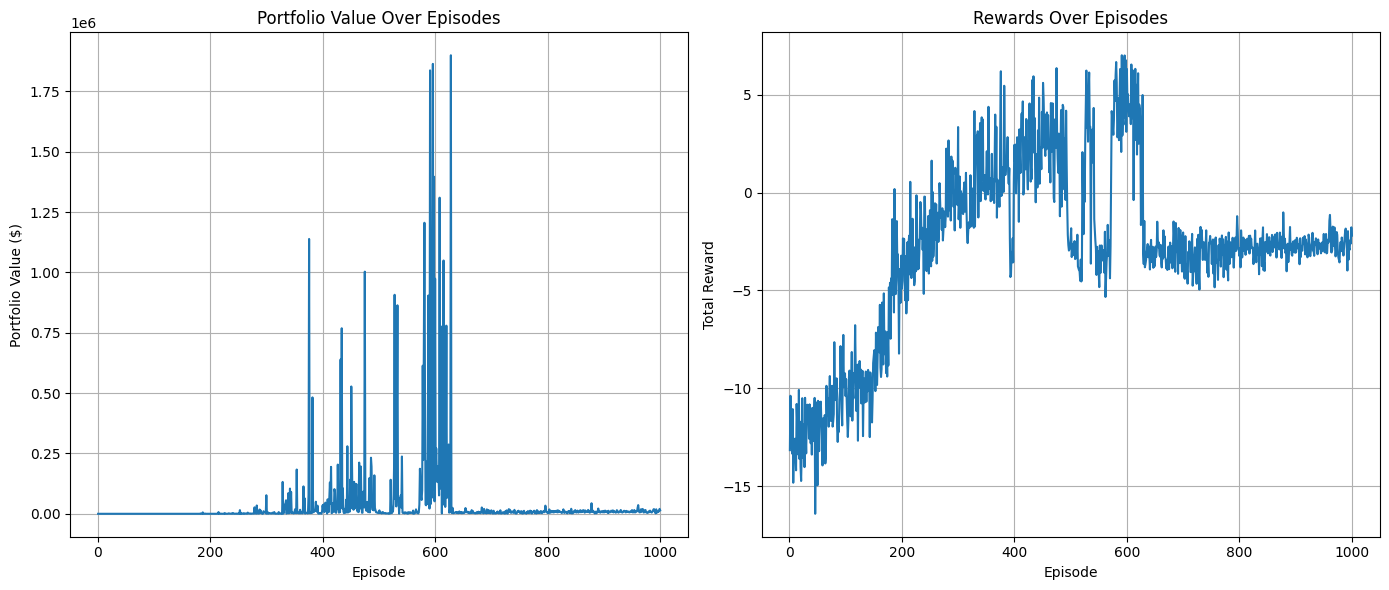

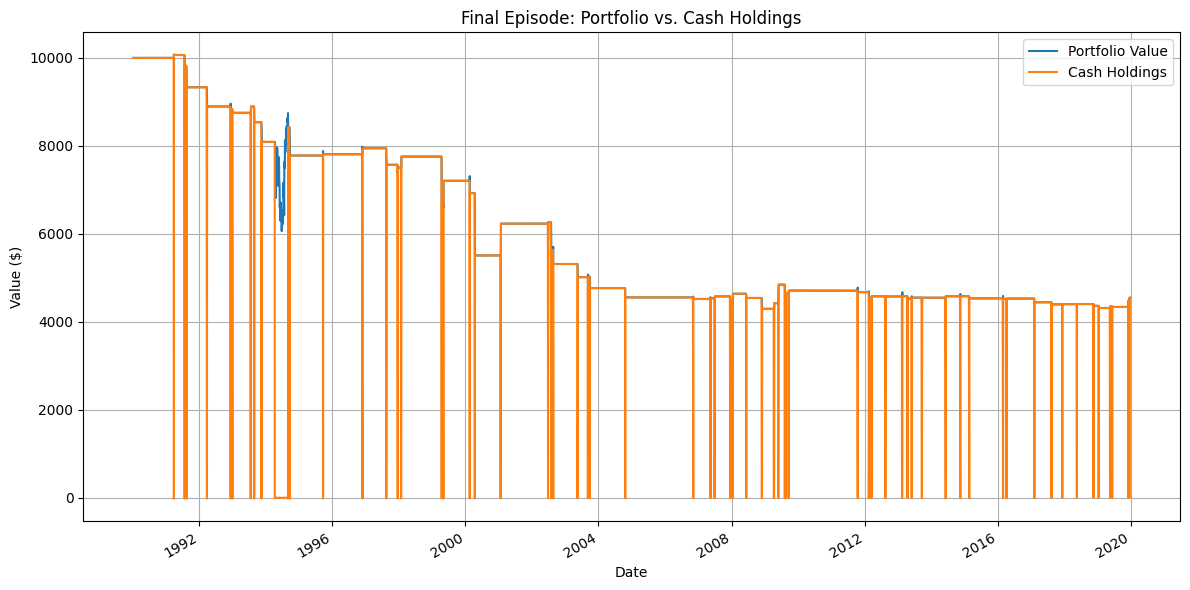

In [28]:
# --------------------------
# Plotting Section
# --------------------------
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# 1) Episode-level performance (Portfolio Value and Rewards over Episodes)
plt.figure(figsize=(14, 6))

# Portfolio Value over Episodes
plt.subplot(1, 2, 1)
plt.plot(range(1, len(portfolio_values) + 1), portfolio_values)
plt.xlabel("Episode")
plt.ylabel("Portfolio Value ($)")
plt.title("Portfolio Value Over Episodes")
plt.grid(True)

# Rewards over Episodes
plt.subplot(1, 2, 2)
plt.plot(range(1, len(episode_rewards) + 1), episode_rewards)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Rewards Over Episodes")
plt.grid(True)

plt.tight_layout()
plt.show()


# 2) Build a DataFrame for the final episode's daily values, indexed by real dates
dates = data.index[:len(daily_values)]
daily_df = pd.DataFrame({
    "Portfolio Value": daily_values,
    "Cash Holdings":   daily_cash
}, index=dates)

for i, ticker in enumerate(tickers):
    daily_df[ticker] = daily_stock_values[i]

# 3) Final Episode: Portfolio vs. Cash Holdings
fig, ax = plt.subplots(figsize=(12, 6))
daily_df[["Portfolio Value", "Cash Holdings"]].plot(ax=ax)
ax.set(
    xlabel="Date",
    ylabel="Value ($)",
    title="Final Episode: Portfolio vs. Cash Holdings"
)
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))
ax.grid(True)
plt.tight_layout()
plt.show()

In [29]:
spy = (
    yf.download("SPY",
                start=dates[0],
                end=dates[-1],
                auto_adjust=False)["Close"]
    .reindex(dates)     # align to your exact days
    .ffill().bfill()
)

[*********************100%***********************]  1 of 1 completed


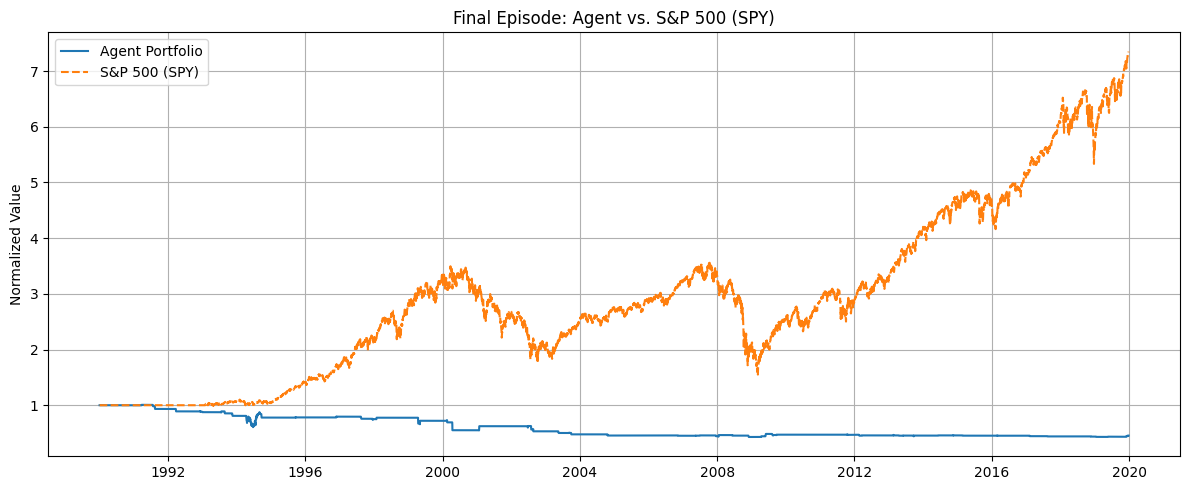

In [30]:
# normalize
norm_port = np.array(daily_values) / daily_values[0]
norm_spy  = spy.values       / spy.values[0]

# plot
import matplotlib.dates as mdates

fig, ax = plt.subplots(figsize=(12,5))
ax.plot(dates, norm_port, label="Agent Portfolio")
ax.plot(dates, norm_spy,  "--", label="S&P 500 (SPY)")
ax.set_title("Final Episode: Agent vs. S&P 500 (SPY)")
ax.set_ylabel("Normalized Value")
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()

### **DQN Testing**

[*********************100%***********************]  71 of 71 completed
[*********************100%***********************]  1 of 1 completed


Evaluation from 2021-01-04 to 2025-04-11
Portfolio Cumulative Return: 0.76%


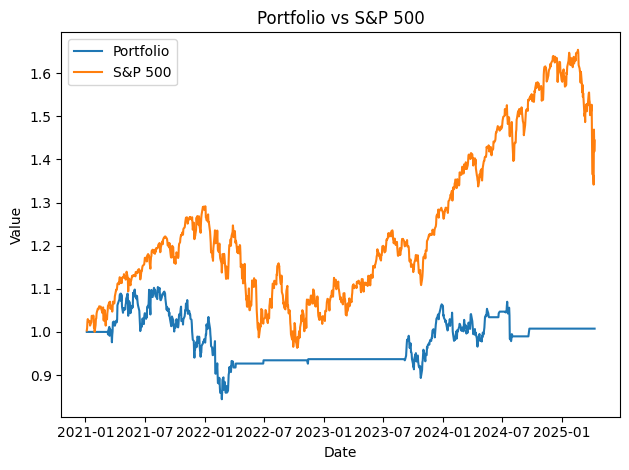

In [31]:
import gym
import numpy as np
import torch
import matplotlib.pyplot as plt
import yfinance as yf
import pandas as pd


def evaluate_agent(agent, tickers, start_date='2020-01-01', end_date=None,
                   initial_cash=10000, transaction_cost=0.001, device=None):
    """
    Runs a single evaluation of a trained BCQ agent over the specified period.

    Args:
        agent: Trained BCQAgent instance (should already be in memory).
        tickers: List of stock tickers used in training.
        start_date: String 'YYYY-MM-DD', start of evaluation.
        end_date: String 'YYYY-MM-DD', end of evaluation. Defaults to latest.
        initial_cash: Starting cash balance.
        transaction_cost: Proportional transaction cost per trade.
        device: torch.device for inference.

    Returns:
        dates: List of evaluation dates.
        portf_values: List of daily portfolio values.
        bench_values: List of daily S&P 500 values.
    """
    # Fetch price data
    data = yf.download(tickers, start=start_date, end=end_date, auto_adjust=False)["Close"]
    data = data.ffill().bfill()
    prices = data.values.astype(np.float32)
    dates = data.index

    # Fetch S&P500
    snp = yf.download('^GSPC', start=start_date, end=end_date, auto_adjust=False)["Close"].ffill().bfill().values

    # Evaluation environment (mirror of TradingEnv)
    class EvalEnv(gym.Env):
        def __init__(self, prices, snp, initial_cash, transaction_cost):
            super().__init__()
            self.prices = prices
            self.snp = snp
            self.initial_cash = initial_cash
            self.num_stocks = prices.shape[1]
            self.transaction_cost = transaction_cost
            self.action_space = gym.spaces.Box(0, 1, (self.num_stocks+1,), np.float32)
            obs_low = np.zeros(self.num_stocks*2+1, np.float32)
            obs_high = np.full(self.num_stocks*2+1, np.inf, np.float32)
            self.observation_space = gym.spaces.Box(obs_low, obs_high, dtype=np.float32)

        def reset(self):
            self.step_idx = 0
            self.cash = float(self.initial_cash)
            self.holdings = np.zeros(self.num_stocks, np.float32)
            return self._obs()

        def _obs(self):
            return np.concatenate([self.prices[self.step_idx], self.holdings, [self.cash]])

        def step(self, action):
            # normalize action
            action = np.clip(action, 1e-6, None)
            action /= action.sum()

            # compute current total value
            prices = self.prices[self.step_idx]
            total_val = (self.holdings * prices).sum() + self.cash

            # determine new holdings and cost
            target_vals = action[:-1] * total_val
            target_cash = action[-1] * total_val
            new_h = target_vals / prices
            trades = np.abs(new_h - self.holdings) * prices
            cost = self.transaction_cost * trades.sum()

            # advance to next step
            next_prices = self.prices[self.step_idx + 1]
            next_stock_val = (new_h * next_prices).sum()
            next_total = next_stock_val + target_cash - cost

            # reward relative to S&P 500
            ret_port = next_total / total_val - 1
            ret_bench = (self.snp[self.step_idx + 1] / self.snp[self.step_idx]) - 1
            reward = ret_port - ret_bench

            # commit
            self.holdings = new_h
            self.cash = target_cash - cost
            self.step_idx += 1
            done = (self.step_idx >= len(self.prices) - 1)
            return self._obs(), reward, done, {}

    # Run evaluation
    env = EvalEnv(prices, snp, initial_cash, transaction_cost)
    state = env.reset()
    portf_vals, bench_vals = [], []

    # force greedy policy
    agent.epsilon = agent.epsilon_min

    while True:
        action = agent.select_action(state)
        state, _, done, _ = env.step(action)
        value = env.cash + (env.holdings * env.prices[env.step_idx]).sum()
        portf_vals.append(value)
        bench_vals.append(env.snp[env.step_idx])
        if done:
            break

    # Performance metrics
    cum_return = (portf_vals[-1] / initial_cash - 1) * 100
    bench_return = (bench_vals[-1] / bench_vals[0] - 1) * 100
    print(f"Evaluation from {dates[0].date()} to {dates[-1].date()}")
    print(f"Portfolio Cumulative Return: {cum_return:.2f}%")
    norm_portf = np.array(portf_vals) / 10000
    norm_bench = np.array(bench_vals) / 3714
    # Plot portfolio vs benchmark
    plt.figure()
    plt.plot(dates[1:],norm_portf,  label='Portfolio')
    plt.plot(dates[1:],norm_bench , label='S&P 500')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.title('Portfolio vs S&P 500')
    plt.legend()
    plt.tight_layout(); plt.show()



swag = evaluate_agent(
    dqn_agent,
    tickers,
    start_date='2021-01-01',
    end_date='2025-04-14',
    initial_cash=10000,
    transaction_cost=0.00001,
    device=device  # if your agent uses device for inference
     )

## **PPO**

### **PPO Agent**

In [43]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

class Actor(nn.Module):
    def __init__(self, state_dim, action_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(state_dim, 128),
            nn.ReLU(),
            nn.Linear(128, action_dim),
        )

    def forward(self, x):
        logits = self.net(x)
        return F.softmax(logits, dim=-1)  # Softmax portfolio weights

class Critic(nn.Module):
    def __init__(self, state_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(state_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        return self.net(x)

class PPOAgent:
    def __init__(self, state_dim, action_dim, device, lr=1e-4, gamma=0.99, clip_eps=0.2,
                 entropy_coef=0.01, epsilon_start=1.0, epsilon_min=0.01, epsilon_decay=0.995):
        self.actor = Actor(state_dim, action_dim).to(device)
        self.critic = Critic(state_dim).to(device)
        self.optimizer = optim.Adam(list(self.actor.parameters()) + list(self.critic.parameters()), lr=lr)
        self.gamma = gamma
        self.clip_eps = clip_eps
        self.entropy_coef = entropy_coef
        self.device = device

        # Epsilon-greedy
        self.epsilon = epsilon_start
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay

    def select_action(self, state):
        state_tensor = torch.FloatTensor(state).unsqueeze(0).to(self.device)

        if np.random.rand() < self.epsilon:
            # Random portfolio weights (uniform then normalize)
            random_weights = np.random.rand(state_tensor.shape[1])
            action = random_weights / random_weights.sum()
        else:
            with torch.no_grad():
                probs = self.actor(state_tensor).cpu().numpy().squeeze()
            action = probs

        # Decay epsilon
        self.epsilon = max(self.epsilon * self.epsilon_decay, self.epsilon_min)

        return action, action 

    def compute_returns(self, rewards, dones, last_value):
        returns = []
        R = last_value
        for r, done in zip(reversed(rewards), reversed(dones)):
            R = r + self.gamma * R * (1 - done)
            returns.insert(0, R)
        return returns

    def update(self, states, actions, old_probs, returns, advantages, epochs=10):
        states = torch.FloatTensor(states).to(self.device)
        actions = torch.FloatTensor(actions).to(self.device)
        old_probs = torch.FloatTensor(old_probs).to(self.device)
        returns = torch.FloatTensor(returns).to(self.device)
        advantages = torch.FloatTensor(advantages).to(self.device)

        for _ in range(epochs):
            new_probs = self.actor(states)

            # Compute ratio and clipped surrogate objective
            ratio = (new_probs / old_probs).sum(dim=1)  # element-wise for softmax weights
            clipped = torch.clamp(ratio, 1 - self.clip_eps, 1 + self.clip_eps)
            surrogate = torch.min(ratio * advantages, clipped * advantages)

            # Value function loss
            value_preds = self.critic(states).squeeze()
            value_loss = F.mse_loss(value_preds, returns)

            # Entropy bonus
            entropy = -(new_probs * new_probs.log()).sum(dim=1).mean()

            # Final loss
            loss = -surrogate.mean() + 0.5 * value_loss - self.entropy_coef * entropy

            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

In [44]:
Transition = namedtuple('Transition', ('state', 'action', 'reward', 'next_state', 'done'))

if __name__ == "__main__":
    # Set random seeds for reproducibility
    start = "1990-01-01"
    end = "2019-12-31"
    random.seed(2004)
    np.random.seed(2004)
    torch.manual_seed(2004)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(2004)
    
    # Device configuration: use GPU if available.
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Using device:", device)
    
    # Stock tickers and data download.
    tickers = fewer_sp500_tickers
    dividends = {}
    for item in tickers:
        ticker_obj = yf.Ticker(item)
        # Use .ffill() instead of .fillna(method='ffill')
        dividends[item] = pd.Series(ticker_obj.dividends[start:end].values.astype(np.float32)).ffill()
    print("Downloading stock data...")
    # Explicitly set auto_adjust and update fillna calls
    data = yf.download(tickers, start=start, end=end, auto_adjust=False)["Close"]
    data = data.ffill().bfill()
    stock_prices = data.values.astype(np.float32)
    
    env = TradingEnv(stock_prices, dividends, initial_cash=10000)
    state_dim  = env.observation_space.shape[0]
    action_dim = env.action_space.shape[0]

    # <-- Use our DQNAgent here -->
    ppo_agent = PPOAgent(
        state_dim,
        action_dim,
        device,
        epsilon_start=1.0,
        epsilon_min=0.01,
        epsilon_decay=0.995
    )

    # Training loop remains *exactly* the same
    num_episodes = 1000
    batch_size   = 128
    print_interval = 100
    episode_rewards = []
    portfolio_values = []
    
    for episode in range(1, num_episodes + 1):
        state = env.reset()
        done = False
        total_reward = 0.0

        # 1) Rollout
        states, actions, old_probs, rewards, dones = [], [], [], [], []
        while not done:
            action, prob = ppo_agent.select_action(state)
            next_state, reward, done, _ = env.step(action)

            states.append(state)
            actions.append(action)
            old_probs.append(prob)
            rewards.append(reward)
            dones.append(done)

            # accumulate reward
            total_reward += reward
            state = next_state

        # 2) Bootstrap last value
        state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
        last_value = ppo_agent.critic(state_tensor).item()

        # 3) Compute returns & advantages
        returns   = ppo_agent.compute_returns(rewards, dones, last_value)
        values    = [
            ppo_agent.critic(torch.FloatTensor(s).unsqueeze(0).to(device)).item()
            for s in states
        ]
        advantages = [ret - val for ret, val in zip(returns, values)]

        # 4) On-policy update
        ppo_agent.update(states, actions, old_probs, returns, advantages)

        # 5) Logging and tracking
        final_prices     = env.stock_prices[-1]
        portfolio_value  = env.cash + np.sum(env.holdings * final_prices)

        episode_rewards.append(total_reward)
        portfolio_values.append(portfolio_value)
        
        if episode % print_interval == 0:
            print(f"Episode {episode}")
            # Convert total_reward to a float before formatting.
            print(f"Reward: ${float(total_reward):.2f} - ")
            print(f"Portfolio Value: ${portfolio_value:.2f} - ")
            print(f"Cash: ${env.cash:.2f} - ")
            print(f"Epsilon: {ppo_agent.epsilon:.4f}")

    print("\nTraining completed!")
    print("\n===== Final Training Episode Summary =====")
    initial_portfolio_value = 10000.00
    final_portfolio_value = portfolio_values[-1]
    total_change = final_portfolio_value - initial_portfolio_value
    percentage_change = (total_change / initial_portfolio_value) * 100

    print(f"Initial Portfolio Value: ${initial_portfolio_value:.2f}")
    print(f"Final Portfolio Value: ${final_portfolio_value:.2f}")
    print(f"Total Change: ${total_change:.2f} ({percentage_change:.2f}%)\n")
    
    print("Stock Breakdown:")
    for i, ticker in enumerate(tickers):
        initial_stock_value = (0 / env.num_stocks)
        final_stock_value = env.holdings[i] * final_prices[i]
        change = final_stock_value - initial_stock_value
        print(f"{ticker}: Initial ${initial_stock_value:.2f}, Final ${final_stock_value:.2f}, Change ${change:.2f}")
    print(f"Cash at End: ${env.cash:.2f}")

Using device: cuda


[                       0%                       ]

[*********************100%***********************]  71 of 71 completed
[*********************100%***********************]  1 of 1 completed


ValueError: operands could not be broadcast together with shapes (142,) (71,) 

### **PPO Visualizations**

In [ ]:
# stock_prices came from a DataFrame `data` whose index is real dates
dates = []
daily_values = []
daily_cash   = []
daily_stock  = []
daily_stock_values = np.zeros(len(tickers))

state = env.reset()
done = False
while not done:
    dates.append(data.index[env.current_step])
    # make your action, step:
    action = dqn_agent.select_action(state)
    next_state, reward, done, _ = env.step(action)
    # record
    prices = env.stock_prices[env.current_step-1]
    total_val = env.cash + (env.holdings * prices).sum()
    daily_values.append(total_val)
    daily_cash.append(env.cash)
    daily_stock.append((env.holdings * prices).tolist())
    state = next_state

In [ ]:
# --------------------------
# Plotting Section
# --------------------------
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# 1) Episode-level performance (Portfolio Value and Rewards over Episodes)
plt.figure(figsize=(14, 6))

# Portfolio Value over Episodes
plt.subplot(1, 2, 1)
plt.plot(range(1, len(portfolio_values) + 1), portfolio_values)
plt.xlabel("Episode")
plt.ylabel("Portfolio Value ($)")
plt.title("Portfolio Value Over Episodes")
plt.grid(True)

# Rewards over Episodes
plt.subplot(1, 2, 2)
plt.plot(range(1, len(episode_rewards) + 1), episode_rewards)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Rewards Over Episodes")
plt.grid(True)

plt.tight_layout()
plt.show()


# 2) Build a DataFrame for the final episode's daily values, indexed by real dates
dates = data.index[:len(daily_values)]
daily_df = pd.DataFrame({
    "Portfolio Value": daily_values,
    "Cash Holdings":   daily_cash
}, index=dates)

for i, ticker in enumerate(tickers):
    daily_df[ticker] = daily_stock_values[i]

# 3) Final Episode: Portfolio vs. Cash Holdings
fig, ax = plt.subplots(figsize=(12, 6))
daily_df[["Portfolio Value", "Cash Holdings"]].plot(ax=ax)
ax.set(
    xlabel="Date",
    ylabel="Value ($)",
    title="Final Episode: Portfolio vs. Cash Holdings"
)
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))
ax.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
spy = (
    yf.download("SPY",
                start=dates[0],
                end=dates[-1],
                auto_adjust=False)["Close"]
    .reindex(dates)     # align to your exact days
    .ffill().bfill()
)

In [ ]:
# normalize
norm_port = np.array(daily_values) / daily_values[0]
norm_spy  = spy.values       / spy.values[0]

# plot
import matplotlib.dates as mdates

fig, ax = plt.subplots(figsize=(12,5))
ax.plot(dates, norm_port, label="Agent Portfolio")
ax.plot(dates, norm_spy,  "--", label="S&P 500 (SPY)")
ax.set_title("Final Episode: Agent vs. S&P 500 (SPY)")
ax.set_ylabel("Normalized Value")
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()

### **PPO Testing**

In [ ]:
import gym
import numpy as np
import torch
import matplotlib.pyplot as plt
import yfinance as yf
import pandas as pd


def evaluate_agent(agent, tickers, start_date='2020-01-01', end_date=None,
                   initial_cash=10000, transaction_cost=0.001, device=None):
    """
    Runs a single evaluation of a trained BCQ agent over the specified period.

    Args:
        agent: Trained BCQAgent instance (should already be in memory).
        tickers: List of stock tickers used in training.
        start_date: String 'YYYY-MM-DD', start of evaluation.
        end_date: String 'YYYY-MM-DD', end of evaluation. Defaults to latest.
        initial_cash: Starting cash balance.
        transaction_cost: Proportional transaction cost per trade.
        device: torch.device for inference.

    Returns:
        dates: List of evaluation dates.
        portf_values: List of daily portfolio values.
        bench_values: List of daily S&P 500 values.
    """
    # Fetch price data
    data = yf.download(tickers, start=start_date, end=end_date, auto_adjust=False)["Close"]
    data = data.ffill().bfill()
    prices = data.values.astype(np.float32)
    dates = data.index

    # Fetch S&P500
    snp = yf.download('^GSPC', start=start_date, end=end_date, auto_adjust=False)["Close"].ffill().bfill().values

    # Evaluation environment (mirror of TradingEnv)
    class EvalEnv(gym.Env):
        def __init__(self, prices, snp, initial_cash, transaction_cost):
            super().__init__()
            self.prices = prices
            self.snp = snp
            self.initial_cash = initial_cash
            self.num_stocks = prices.shape[1]
            self.transaction_cost = transaction_cost
            self.action_space = gym.spaces.Box(0, 1, (self.num_stocks+1,), np.float32)
            obs_low = np.zeros(self.num_stocks*2+1, np.float32)
            obs_high = np.full(self.num_stocks*2+1, np.inf, np.float32)
            self.observation_space = gym.spaces.Box(obs_low, obs_high, dtype=np.float32)

        def reset(self):
            self.step_idx = 0
            self.cash = float(self.initial_cash)
            self.holdings = np.zeros(self.num_stocks, np.float32)
            return self._obs()

        def _obs(self):
            return np.concatenate([self.prices[self.step_idx], self.holdings, [self.cash]])

        def step(self, action):
            # normalize action
            action = np.clip(action, 1e-6, None)
            action /= action.sum()

            # compute current total value
            prices = self.prices[self.step_idx]
            total_val = (self.holdings * prices).sum() + self.cash

            # determine new holdings and cost
            target_vals = action[:-1] * total_val
            target_cash = action[-1] * total_val
            new_h = target_vals / prices
            trades = np.abs(new_h - self.holdings) * prices
            cost = self.transaction_cost * trades.sum()

            # advance to next step
            next_prices = self.prices[self.step_idx + 1]
            next_stock_val = (new_h * next_prices).sum()
            next_total = next_stock_val + target_cash - cost

            # reward relative to S&P 500
            ret_port = next_total / total_val - 1
            ret_bench = (self.snp[self.step_idx + 1] / self.snp[self.step_idx]) - 1
            reward = ret_port - ret_bench

            # commit
            self.holdings = new_h
            self.cash = target_cash - cost
            self.step_idx += 1
            done = (self.step_idx >= len(self.prices) - 1)
            return self._obs(), reward, done, {}

    # Run evaluation
    env = EvalEnv(prices, snp, initial_cash, transaction_cost)
    state = env.reset()
    portf_vals, bench_vals = [], []

    # force greedy policy
    agent.epsilon = agent.epsilon_min

    while True:
        action = agent.select_action(state)
        state, _, done, _ = env.step(action)
        value = env.cash + (env.holdings * env.prices[env.step_idx]).sum()
        portf_vals.append(value)
        bench_vals.append(env.snp[env.step_idx])
        if done:
            break

    # Performance metrics
    cum_return = (portf_vals[-1] / initial_cash - 1) * 100
    bench_return = (bench_vals[-1] / bench_vals[0] - 1) * 100
    print(f"Evaluation from {dates[0].date()} to {dates[-1].date()}")
    print(f"Portfolio Cumulative Return: {cum_return:.2f}%")
    norm_portf = np.array(portf_vals) / 10000
    norm_bench = np.array(bench_vals) / 3714
    # Plot portfolio vs benchmark
    plt.figure()
    plt.plot(dates[1:],norm_portf,  label='Portfolio')
    plt.plot(dates[1:],norm_bench , label='S&P 500')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.title('Portfolio vs S&P 500')
    plt.legend()
    plt.tight_layout(); plt.show()



swag = evaluate_agent(
    ppo_agent,
    tickers,
    start_date='2021-01-01',
    end_date='2025-04-14',
    initial_cash=10000,
    transaction_cost=0.00001,
    device=device  # if your agent uses device for inference
     )

## **CQL**

### **CQL Agent**

In [32]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)
   
    def push(self, *args):
        self.buffer.append(Transition(*args))
   
    def sample(self, batch_size):
        transitions = random.sample(self.buffer, batch_size)
        return Transition(*zip(*transitions))
   
    def __len__(self):
        return len(self.buffer)

class QNetwork(nn.Module):
    def __init__(self, state_dim, action_dim):
        super().__init__()
        self.fc1 = nn.Linear(state_dim + action_dim, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, 1)

    def forward(self, state, action):
        x = torch.cat([state, action], 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

class Actor(nn.Module):
    def __init__(self, state_dim, action_dim):
        super().__init__()
        self.fc1 = nn.Linear(state_dim, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, action_dim)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return self.softmax(self.fc3(x))

class CQLAgent:
    def __init__(self, state_dim, action_dim, device, gamma=0.95, tau=0.005, alpha=1.0, num_samples=20, epsilon_start = .95, epsilon_min = .05, epsilon_decay = 20):
        self.device = device
        self.gamma = gamma
        self.tau = tau
        self.alpha = alpha
        self.num_samples = num_samples
        self.epsilon = epsilon_start
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay

        # Actor networks
        self.actor = Actor(state_dim, action_dim).to(device)
        self.actor_target = Actor(state_dim, action_dim).to(device)
        self.actor_target.load_state_dict(self.actor.state_dict())
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=1e-3)

        # Critic networks
        self.critic = QNetwork(state_dim, action_dim).to(device)
        self.critic_target = QNetwork(state_dim, action_dim).to(device)
        self.critic_target.load_state_dict(self.critic.state_dict())
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=1e-4)

    def select_action(self, state, epsilon=0.1):
        if np.random.random() < self.epsilon:
            return np.random.dirichlet(np.ones(self.actor.fc3.out_features))
        state = torch.FloatTensor(state).unsqueeze(0).to(self.device)
        with torch.no_grad():
            action = self.actor(state).cpu().numpy()[0]
        return action

    def update(self, buffer, batch_size):
        if len(buffer) < batch_size:
            return None, None

        batch = buffer.sample(batch_size)

        # Convert to tensors with proper shape handling
        states = torch.FloatTensor(np.vstack(batch.state)).to(self.device)
        actions = torch.FloatTensor(np.vstack(batch.action)).to(self.device)

        # Handle rewards - convert to list first to handle scalar values
        rewards_list = [np.array(r, dtype=np.float32) for r in batch.reward]
        rewards = torch.FloatTensor(np.vstack(rewards_list)).unsqueeze(1).to(self.device)

        next_states = torch.FloatTensor(np.vstack(batch.next_state)).to(self.device)

        # Handle done flags - convert to list first to handle scalar values
        dones_list = [np.array(d, dtype=np.float32) for d in batch.done]
        dones = torch.FloatTensor(np.vstack(dones_list)).unsqueeze(1).to(self.device)

        # Critic update
        with torch.no_grad():
            next_actions = self.actor_target(next_states)
            next_Q = self.critic_target(next_states, next_actions)
            target_Q = rewards + (1 - dones) * self.gamma * next_Q

        current_Q = self.critic(states, actions)
        td_loss = F.mse_loss(current_Q, target_Q)

        # CQL regularization
        batch_size = states.size(0)
        action_dim = self.actor.fc3.out_features

        # Sample random actions using Dirichlet distribution
        sampled_actions = torch.distributions.Dirichlet(
            torch.ones(action_dim, device=self.device)
        ).sample((batch_size, self.num_samples))

        states_repeated = states.unsqueeze(1).repeat(1, self.num_samples, 1)
        states_repeated = states_repeated.view(batch_size * self.num_samples, -1)
        sampled_actions_flat = sampled_actions.view(-1, action_dim)

        # Compute Q-values for sampled actions
        sampled_Q = self.critic(states_repeated, sampled_actions_flat)
        sampled_Q = sampled_Q.view(batch_size, self.num_samples)

        # Combine with data Q-values
        data_Q = current_Q.detach()
        combined_Q = torch.cat([sampled_Q, data_Q], dim=1)
        cql_loss = torch.logsumexp(combined_Q, dim=1).mean() - data_Q.mean()

        # Total critic loss
        critic_loss = td_loss + self.alpha * cql_loss

        # Optimize critic
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.critic.parameters(), 1.0)
        self.critic_optimizer.step()

        # Actor update
        policy_actions = self.actor(states)                      # shape (B, A)
        q_vals        = self.critic(states, policy_actions)      # shape (B, 1)

        # compute per-state entropy H(pi) = − Σ_i pi_i log(pi_i)
        entropy = - (policy_actions * (policy_actions + 1e-8).log()).sum(dim=1)  # shape (B,)

        # maximize Q + β⋅H  ⇒  minimize −(Q + β H)
        beta       = 1e-2   # tune this: higher → more uniform policies
        actor_loss = -(q_vals.squeeze() + beta * entropy).mean()

        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.actor.parameters(), 1.0)
        self.actor_optimizer.step()

        # Update target networks
        with torch.no_grad():
            for target_param, param in zip(self.critic_target.parameters(), self.critic.parameters()):
                target_param.data.mul_(1 - self.tau)
                target_param.data.add_(self.tau * param.data)

            for target_param, param in zip(self.actor_target.parameters(), self.actor.parameters()):
                target_param.data.mul_(1 - self.tau)
                target_param.data.add_(self.tau * param.data)

        return critic_loss.item(), actor_loss.item()

In [ ]:
Transition = namedtuple('Transition', ('state', 'action', 'reward', 'next_state', 'done'))

if __name__ == "__main__":
    # Set random seeds for reproducibility
    start = "1990-01-01"
    end = "2019-12-31"
    random.seed(2004)
    np.random.seed(2004)
    torch.manual_seed(2004)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(2004)
    
    # Device configuration: use GPU if available.
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Using device:", device)
    
    env = TradingEnv(
    prices_arr,
    vols_arr,
    divs_arr,
    ma30_arr,
    slopes_arr,
    unemp_arr,
    irate_arr,
    initial_cash=10000)
    
    state_dim  = env.observation_space.shape[0]
    action_dim = env.action_space.shape[0]
    
    # Initialize BCQ agent with epsilon decay parameters.
    cql_agent = CQLAgent(state_dim, action_dim, device,
                     epsilon_start=1.0, epsilon_min=0.01, epsilon_decay=0.995)
    replay_buffer = ReplayBuffer(100000)
    
    # Training parameters.
    num_episodes = 1500
    batch_size = 128
    print_interval = 100
    episode_rewards = []
    portfolio_values = []
    
    print("Starting training...")
    for episode in range(1, num_episodes + 1):
        state = env.reset()
        done = False
        total_reward = 0.0
        
        while not done:
            action = cql_agent.select_action(state)
            next_state, reward, done, _ = env.step(action)
            replay_buffer.push(state, action, reward, next_state, done)
            state = next_state
            total_reward += reward
        cql_agent.epsilon = max(cql_agent.epsilon * cql_agent.epsilon_decay, cql_agent.epsilon_min)
        cql_agent.update(replay_buffer, batch_size)
        
        
        final_prices = env.prices[-1]
        portfolio_value = env.cash + np.sum(env.holdings * final_prices)
        episode_rewards.append(total_reward)
        portfolio_values.append(portfolio_value)
        
        if episode % print_interval == 0:
            print(f"Episode {episode}")
            # Convert total_reward to a float before formatting.
            print(f"Reward: ${float(total_reward):.2f} - ")
            print(f"Portfolio Value: ${portfolio_value:.2f} - ")
            print(f"Cash: ${env.cash:.2f} - ")
            print(f"Epsilon: {cql_agent.epsilon:.4f}")

    print("\nTraining completed!")
    print("\n===== Final Training Episode Summary =====")
    initial_portfolio_value = 10000.00
    final_portfolio_value = portfolio_values[-1]
    total_change = final_portfolio_value - initial_portfolio_value
    percentage_change = (total_change / initial_portfolio_value) * 100

    print(f"Initial Portfolio Value: ${initial_portfolio_value:.2f}")
    print(f"Final Portfolio Value: ${final_portfolio_value:.2f}")
    print(f"Total Change: ${total_change:.2f} ({percentage_change:.2f}%)\n")
    
    print("Stock Breakdown:")
    for i, ticker in enumerate(tickers):
        initial_stock_value = 0
        final_stock_value = env.holdings[i] * final_prices[i]
        change = final_stock_value - initial_stock_value
        print(f"{ticker}: Initial ${initial_stock_value:.2f}, Final ${final_stock_value:.2f}, Change ${change:.2f}")
    print(f"Cash at End: ${env.cash:.2f}")

[*********************100%***********************]  1 of 1 completed

Using device: cuda
Starting training...



/scratch/4597531.1.academic-gpu/ipykernel_126392/1321952863.py:99: UserWarning: Using a target size (torch.Size([128, 128, 1])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  td_loss = F.mse_loss(current_Q, target_Q)


Episode 100
Reward: $-6.34 - 
Portfolio Value: $185.21 - 
Cash: $2.75 - 
Epsilon: 0.6058


/scratch/4597531.1.academic-gpu/ipykernel_126392/1381447722.py:66: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print(f"Reward: ${float(total_reward):.2f} - ")


Episode 200
Reward: $-5.98 - 
Portfolio Value: $299.18 - 
Cash: $0.09 - 
Epsilon: 0.3670
Episode 300
Reward: $-4.11 - 
Portfolio Value: $2097.73 - 
Cash: $97.10 - 
Epsilon: 0.2223
Episode 400
Reward: $-3.80 - 
Portfolio Value: $2975.72 - 
Cash: $2975.72 - 
Epsilon: 0.1347
Episode 500
Reward: $-3.33 - 
Portfolio Value: $4829.04 - 
Cash: $4829.04 - 
Epsilon: 0.0816


### **CQL Visualizations**

In [59]:
# stock_prices came from a DataFrame `data` whose index is real dates
dates = []
daily_values = []
daily_cash   = []
daily_stock  = []
daily_stock_values = np.zeros(len(tickers))

state = env.reset()
done = False
while not done:
    dates.append(data.index[env.current_step])
    # make your action, step:
    action = cql_agent.select_action(state)
    next_state, reward, done, _ = env.step(action)
    # record
    prices = env.stock_prices[env.current_step-1]
    total_val = env.cash + (env.holdings * prices).sum()
    daily_values.append(total_val)
    daily_cash.append(env.cash)
    daily_stock.append((env.holdings * prices).tolist())
    state = next_state

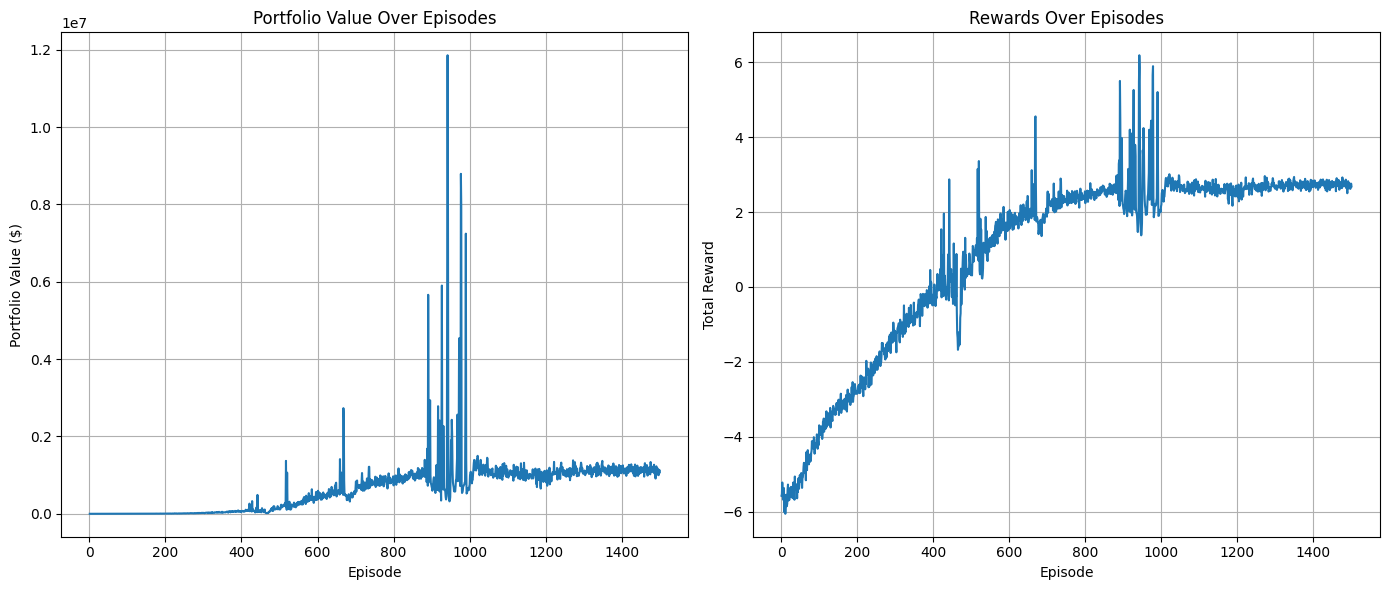

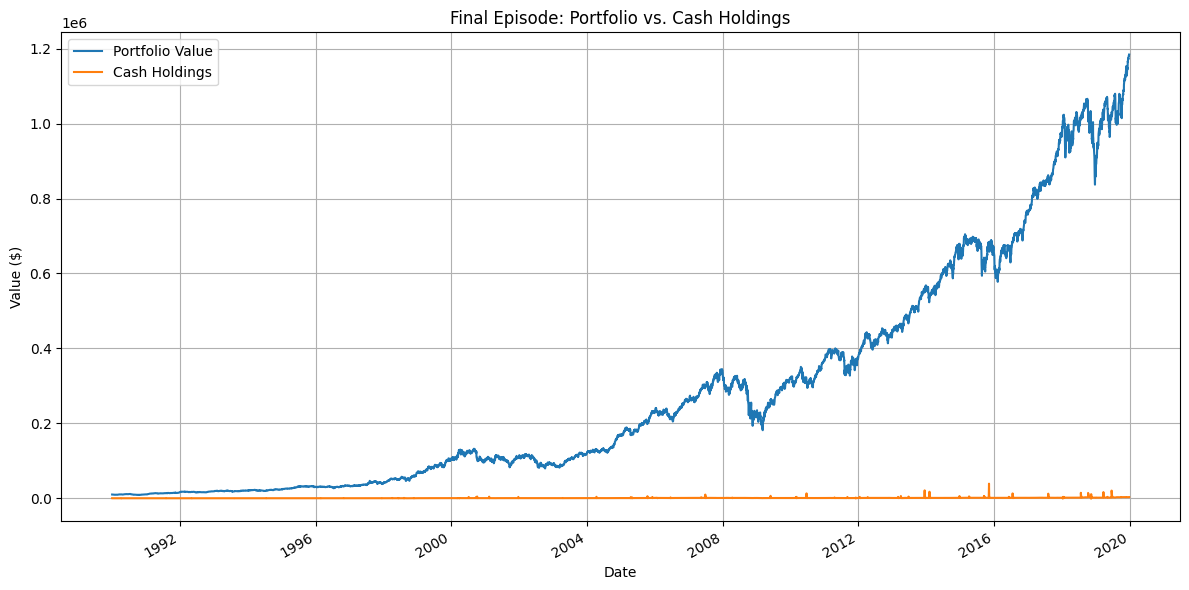

In [60]:
# --------------------------
# Plotting Section
# --------------------------
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# 1) Episode-level performance (Portfolio Value and Rewards over Episodes)
plt.figure(figsize=(14, 6))

# Portfolio Value over Episodes
plt.subplot(1, 2, 1)
plt.plot(range(1, len(portfolio_values) + 1), portfolio_values)
plt.xlabel("Episode")
plt.ylabel("Portfolio Value ($)")
plt.title("Portfolio Value Over Episodes")
plt.grid(True)

# Rewards over Episodes
plt.subplot(1, 2, 2)
plt.plot(range(1, len(episode_rewards) + 1), episode_rewards)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Rewards Over Episodes")
plt.grid(True)

plt.tight_layout()
plt.show()


# 2) Build a DataFrame for the final episode's daily values, indexed by real dates
dates = data.index[:len(daily_values)]
daily_df = pd.DataFrame({
    "Portfolio Value": daily_values,
    "Cash Holdings":   daily_cash
}, index=dates)

for i, ticker in enumerate(tickers):
    daily_df[ticker] = daily_stock_values[i]

# 3) Final Episode: Portfolio vs. Cash Holdings
fig, ax = plt.subplots(figsize=(12, 6))
daily_df[["Portfolio Value", "Cash Holdings"]].plot(ax=ax)
ax.set(
    xlabel="Date",
    ylabel="Value ($)",
    title="Final Episode: Portfolio vs. Cash Holdings"
)
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))
ax.grid(True)
plt.tight_layout()
plt.show()

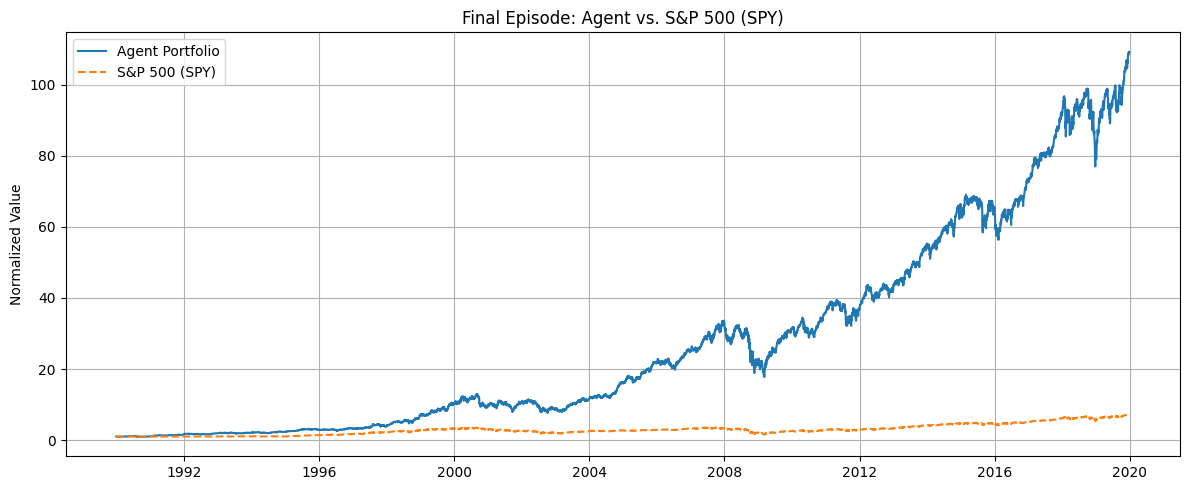

In [57]:
# normalize
norm_port = np.array(daily_values) / daily_values[0]
norm_spy  = spy.values       / spy.values[0]

# plot
import matplotlib.dates as mdates

fig, ax = plt.subplots(figsize=(12,5))
ax.plot(dates, norm_port, label="Agent Portfolio")
ax.plot(dates, norm_spy,  "--", label="S&P 500 (SPY)")
ax.set_title("Final Episode: Agent vs. S&P 500 (SPY)")
ax.set_ylabel("Normalized Value")
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()

### **CQL Testing**

[*********************100%***********************]  71 of 71 completed
[*********************100%***********************]  1 of 1 completed


Evaluation from 2021-01-04 to 2025-04-11
Portfolio Cumulative Return: 75.28%


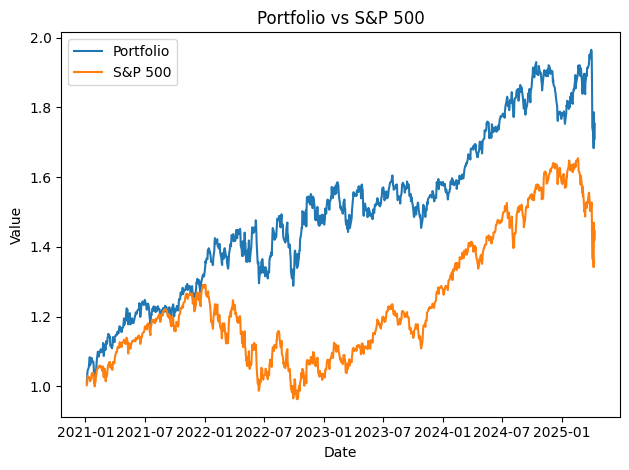

In [58]:
import gym
import numpy as np
import torch
import matplotlib.pyplot as plt
import yfinance as yf
import pandas as pd


def evaluate_agent(agent, tickers, start_date='2020-01-01', end_date=None,
                   initial_cash=10000, transaction_cost=0.001, device=None):
    """
    Runs a single evaluation of a trained BCQ agent over the specified period.

    Args:
        agent: Trained BCQAgent instance (should already be in memory).
        tickers: List of stock tickers used in training.
        start_date: String 'YYYY-MM-DD', start of evaluation.
        end_date: String 'YYYY-MM-DD', end of evaluation. Defaults to latest.
        initial_cash: Starting cash balance.
        transaction_cost: Proportional transaction cost per trade.
        device: torch.device for inference.

    Returns:
        dates: List of evaluation dates.
        portf_values: List of daily portfolio values.
        bench_values: List of daily S&P 500 values.
    """
    # Fetch price data
    data = yf.download(tickers, start=start_date, end=end_date, auto_adjust=False)["Close"]
    data = data.ffill().bfill()
    prices = data.values.astype(np.float32)
    dates = data.index

    # Fetch S&P500
    snp = yf.download('^GSPC', start=start_date, end=end_date, auto_adjust=False)["Close"].ffill().bfill().values

    # Evaluation environment (mirror of TradingEnv)
    class EvalEnv(gym.Env):
        def __init__(self, prices, snp, initial_cash, transaction_cost):
            super().__init__()
            self.prices = prices
            self.snp = snp
            self.initial_cash = initial_cash
            self.num_stocks = prices.shape[1]
            self.transaction_cost = transaction_cost
            self.action_space = gym.spaces.Box(0, 1, (self.num_stocks+1,), np.float32)
            obs_low = np.zeros(self.num_stocks*2+1, np.float32)
            obs_high = np.full(self.num_stocks*2+1, np.inf, np.float32)
            self.observation_space = gym.spaces.Box(obs_low, obs_high, dtype=np.float32)

        def reset(self):
            self.step_idx = 0
            self.cash = float(self.initial_cash)
            self.holdings = np.zeros(self.num_stocks, np.float32)
            return self._obs()

        def _obs(self):
            return np.concatenate([self.prices[self.step_idx], self.holdings, [self.cash]])

        def step(self, action):
            # normalize action
            action = np.clip(action, 1e-6, None)
            action /= action.sum()

            # compute current total value
            prices = self.prices[self.step_idx]
            total_val = (self.holdings * prices).sum() + self.cash

            # determine new holdings and cost
            target_vals = action[:-1] * total_val
            target_cash = action[-1] * total_val
            new_h = target_vals / prices
            trades = np.abs(new_h - self.holdings) * prices
            cost = self.transaction_cost * trades.sum()

            # advance to next step
            next_prices = self.prices[self.step_idx + 1]
            next_stock_val = (new_h * next_prices).sum()
            next_total = next_stock_val + target_cash - cost

            # reward relative to S&P 500
            ret_port = next_total / total_val - 1
            ret_bench = (self.snp[self.step_idx + 1] / self.snp[self.step_idx]) - 1
            reward = ret_port - ret_bench

            # commit
            self.holdings = new_h
            self.cash = target_cash - cost
            self.step_idx += 1
            done = (self.step_idx >= len(self.prices) - 1)
            return self._obs(), reward, done, {}

    # Run evaluation
    env = EvalEnv(prices, snp, initial_cash, transaction_cost)
    state = env.reset()
    portf_vals, bench_vals = [], []

    # force greedy policy
    agent.epsilon = agent.epsilon_min

    while True:
        action = agent.select_action(state)
        state, _, done, _ = env.step(action)
        value = env.cash + (env.holdings * env.prices[env.step_idx]).sum()
        portf_vals.append(value)
        bench_vals.append(env.snp[env.step_idx])
        if done:
            break

    # Performance metrics
    cum_return = (portf_vals[-1] / initial_cash - 1) * 100
    bench_return = (bench_vals[-1] / bench_vals[0] - 1) * 100
    print(f"Evaluation from {dates[0].date()} to {dates[-1].date()}")
    print(f"Portfolio Cumulative Return: {cum_return:.2f}%")
    norm_portf = np.array(portf_vals) / 10000
    norm_bench = np.array(bench_vals) / 3714
    # Plot portfolio vs benchmark
    plt.figure()
    plt.plot(dates[1:],norm_portf,  label='Portfolio')
    plt.plot(dates[1:],norm_bench , label='S&P 500')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.title('Portfolio vs S&P 500')
    plt.legend()
    plt.tight_layout(); plt.show()



swag = evaluate_agent(
    cql_agent,
    tickers,
    start_date='2021-01-01',
    end_date='2025-04-14',
    initial_cash=10000,
    transaction_cost=0.00001,
    device=device  # if your agent uses device for inference
     )

## **Stock Sampling**

In [3]:
import gym
import numpy as np
import yfinance as yf
from gym.spaces import Box

class TradingEnv(gym.Env):
    """
    A Gym environment that samples a random subset of stocks each episode.

    On each reset(), it picks `sample_size` tickers from the full universe,
    aligns prices and S&P 500, and maintains the selected ticker names.

    Args:
        full_stock_prices (np.ndarray): Price matrix of shape (T, N_full).
        full_dividends (dict): Mapping from ticker to dividend Series.
        sample_size (int): Number of stocks to sample each episode.
        full_tickers (list[str], optional): Ticker list matching columns of full_stock_prices.
            If None, inferred from full_dividends keys (in insertion order).
        initial_cash (float): Starting cash balance.
        transaction_cost (float): Fractional cost per dollar traded.
        start (str): S&P start date (YYYY-MM-DD).
        end (str): S&P end date (YYYY-MM-DD).
    """
    def __init__(
        self,
        full_stock_prices: np.ndarray,
        full_dividends: dict,
        sample_size: int = 10,
        full_tickers: list = None,
        initial_cash: float = 10_000,
        transaction_cost: float = 1e-3,
        start: str = '1990-01-01',
        end: str   = '2019-12-31'
    ):
        super().__init__()
        # Full universe of prices and dividends
        self.full_prices      = full_stock_prices.astype(np.float32)
        self.full_dividends   = full_dividends
        self.sample_size      = sample_size
        self.initial_cash     = initial_cash
        self.transaction_cost = transaction_cost

        # Determine ticker list order
        if full_tickers is not None:
            self.full_tickers = list(full_tickers)
        else:
            self.full_tickers = list(full_dividends.keys())

        # Load S&P 500 data once
        snp = yf.download('^GSPC', start=start, end=end,
                          auto_adjust=False)['Close'].values.astype(np.float32)
        min_len = min(self.full_prices.shape[0], len(snp))
        self.full_prices = self.full_prices[:min_len]
        self.snp500       = snp[:min_len]

        # Define fixed action and observation spaces
        self.action_space = Box(
            low=0, high=1,
            shape=(self.sample_size + 1,),
            dtype=np.float32
        )
        obs_dim = self.sample_size * 2 + 1
        self.observation_space = Box(
            low=np.zeros(obs_dim, np.float32),
            high=np.full(obs_dim, np.inf, np.float32),
            dtype=np.float32
        )

        # Placeholders for episode-specific state
        self.stock_prices = None
        self.num_stocks   = None
        self.tickers      = None

    def reset(self):
        # Sample a fresh subset of stocks each episode
        idx = np.random.choice(
            self.full_prices.shape[1], size=self.sample_size, replace=False
        )
        self.stock_prices = self.full_prices[:, idx]
        self.num_stocks   = self.sample_size
        self.tickers      = [self.full_tickers[i] for i in idx]

        # Reset portfolio state
        self.current_step = 0
        self.cash         = float(self.initial_cash)
        self.holdings     = np.zeros(self.num_stocks, dtype=np.float32)
        return self._get_obs()

    def _get_obs(self):
        prices = self.stock_prices[self.current_step]
        return np.concatenate([prices, self.holdings, [self.cash]])

    def step(self, action):
        # Terminate if at end of price series
        if self.current_step >= len(self.stock_prices) - 1:
            return self._get_obs(), 0.0, True, {}

        # Normalize action to sum to 1
        action = np.clip(action, 1e-6, None)
        action = action / action.sum()

        # Current portfolio valuation
        prices      = self.stock_prices[self.current_step]
        stock_vals  = self.holdings * prices
        total_value = stock_vals.sum() + self.cash

        # Compute turnover and cost
        raw_targets    = action[:-1] * total_value
        new_holdings   = raw_targets / prices
        trades         = np.abs(new_holdings - self.holdings) * prices
        turnover       = trades.sum()
        cost           = self.transaction_cost * turnover

        # Deduct cost before reallocation
        net_value         = total_value - cost
        target_stock_vals = action[:-1] * net_value
        target_cash_val   = action[-1]  * net_value
        new_holdings      = target_stock_vals / prices

        # Advance one day and compute reward
        next_prices      = self.stock_prices[self.current_step + 1]
        next_stock_value = (new_holdings * next_prices).sum()
        next_total_value = next_stock_value + target_cash_val

        daily_portf_ret = (next_total_value / total_value) - 1
        snp_today       = self.snp500[self.current_step]
        snp_next        = self.snp500[self.current_step + 1]
        daily_snp_ret   = (snp_next / snp_today) - 1
        reward          = daily_portf_ret - daily_snp_ret

        # Update internal state
        self.holdings     = new_holdings
        self.cash         = target_cash_val
        self.current_step += 1
        done             = (self.current_step >= len(self.stock_prices) - 1)
        return self._get_obs(), reward, done, {}

    def get_portfolio_breakdown(self):
        """
        Returns a dict mapping sampled tickers to their final dollar value,
        computed as holding * last price. Call after the final step.
        """
        if self.stock_prices is None or self.holdings is None:
            return {}
        final_prices = self.stock_prices[-1]
        return {
            ticker: float(holding * price)
            for ticker, holding, price in zip(self.tickers, self.holdings, final_prices)
        }

    def render(self, mode='human'):
        prices = self.stock_prices[self.current_step - 1]
        val    = self.cash + (self.holdings * prices).sum()
        print(f"Day {self.current_step} | Portfolio Value: ${val:.2f} | Cash: ${self.cash:.2f}")

In [10]:
Transition = namedtuple('Transition', ('state', 'action', 'reward', 'next_state', 'done'))

if __name__ == "__main__":
    # Set random seeds for reproducibility
    start = "1990-01-01"
    end = "2019-12-31"
    random.seed(2004)
    np.random.seed(2004)
    torch.manual_seed(2004)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(2004)
    
    # Device configuration: use GPU if available.
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Using device:", device)
    
    # Stock tickers and data download.
    tickers = fewer_sp500_tickers
    dividends = {}
    for item in tickers:
        ticker_obj = yf.Ticker(item)
        # Use .ffill() instead of .fillna(method='ffill')
        dividends[item] = pd.Series(ticker_obj.dividends[start:end].values.astype(np.float32)).ffill()
    print("Downloading stock data...")
    # Explicitly set auto_adjust and update fillna calls
    data = yf.download(tickers, start=start, end=end, auto_adjust=False)["Close"]
    data = data.ffill().bfill()
    stock_prices = data.values.astype(np.float32)
    
    # Create environment.
    env = TradingEnv(stock_prices, dividends, sample_size=20)
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.shape[0]
    
    # Initialize BCQ agent with epsilon decay parameters.
    agent = CQLAgent(state_dim, action_dim, device,
                     epsilon_start=1.0, epsilon_min=0.05, epsilon_decay=0.995)
    replay_buffer = ReplayBuffer(100000)
    
    # Training parameters.
    num_episodes = 2000
    batch_size = 128
    print_interval = 100
    episode_rewards = []
    portfolio_values = []
    
    print("Starting training...")
    for episode in range(num_episodes):
        state = env.reset()
        done = False
        total_reward = 0.0
       
        while not done:
            action = agent.select_action(state)
            next_state, reward, done, _ = env.step(action)
            replay_buffer.push(state, action, reward, next_state, done)
            state = next_state
            total_reward += reward
        agent.epsilon = max(agent.epsilon * agent.epsilon_decay, agent.epsilon_min)
        agent.update(replay_buffer, batch_size)
        
        final_prices = env.stock_prices[-1]
        portfolio_value = env.cash + np.sum(env.holdings * final_prices)
        episode_rewards.append(total_reward)
        portfolio_values.append(portfolio_value)
        
        if episode % print_interval == 0:
            print(f"Episode {episode}")
            # Convert total_reward to a float before formatting.
            print(f"Reward: ${float(total_reward):.2f} - ")
            print(f"Portfolio Value: ${portfolio_value:.2f} - ")
            print(f"Cash: ${env.cash:.2f} - ")
            print(f"Epsilon: {agent.epsilon:.4f}")

    print("\nTraining completed!")
    print("\n===== Final Training Episode Summary =====")
    initial_portfolio_value = 10000.00
    final_portfolio_value = portfolio_values[-1]
    total_change = final_portfolio_value - initial_portfolio_value
    percentage_change = (total_change / initial_portfolio_value) * 100

    print(f"Initial Portfolio Value: ${initial_portfolio_value:.2f}")
    print(f"Final Portfolio Value: ${final_portfolio_value:.2f}")
    print(f"Total Change: ${total_change:.2f} ({percentage_change:.2f}%)\n")
    
    print("Stock Breakdown:")
    for i, ticker in enumerate(env.tickers):
        initial_stock_value = (0 / env.num_stocks)
        final_stock_value = env.holdings[i] * final_prices[i]
        change = final_stock_value - initial_stock_value
        print(f"{ticker}: Initial ${initial_stock_value:.2f}, Final ${final_stock_value:.2f}, Change ${change:.2f}")
    print(f"Cash at End: ${env.cash:.2f}")

Using device: cuda


[*********************100%***********************]  71 of 71 completed
[*********************100%***********************]  1 of 1 completed


Starting training...
Episode 0
Reward: $-5.07 - 
Portfolio Value: $571.80 - 
Cash: $11.59 - 
Epsilon: 0.9950


/scratch/4544293.1.l40s/ipykernel_777101/1485614646.py:99: UserWarning: Using a target size (torch.Size([128, 128, 1])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  td_loss = F.mse_loss(current_Q, target_Q)
/scratch/4544293.1.l40s/ipykernel_777101/217755200.py:70: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print(f"Reward: ${float(total_reward):.2f} - ")


Episode 100
Reward: $-5.95 - 
Portfolio Value: $179.13 - 
Cash: $10.24 - 
Epsilon: 0.6027
Episode 200
Reward: $-6.23 - 
Portfolio Value: $152.00 - 
Cash: $0.26 - 
Epsilon: 0.3651
Episode 300
Reward: $-4.19 - 
Portfolio Value: $924.51 - 
Cash: $0.47 - 
Epsilon: 0.2212


KeyboardInterrupt: 